# Few-shots evaluation of Gemini Pro

In [2]:
#@title Configure Gemini API key

from google.colab import userdata

#Access your Gemini API key

!pip install -q -U google-generativeai
import google.generativeai as genai
from google.colab import userdata

try:
  GOOGLE_API_KEY=userdata.get('gemini_api_secret_name')
  genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
   print(f'''Secret not found

This expects you to create a secret named {gemini_api_secret_name} in Colab

Visit https://makersuite.google.com/app/apikey to create an API key

Store that in the secrets section on the left side of the notebook (key icon)

Name the secret {gemini_api_secret_name}''')
   raise e
except userdata.NotebookAccessError as e:
  print(f'''You need to grant this notebook access to the {gemini_api_secret_name} secret in order for the notebook to access Gemini on your behalf.''')
  raise e
except Exception as e:
  # unknown error
  print(f"There was an unknown error. Ensure you have a secret {gemini_api_secret_name} stored in Colab and it's a valid key from https://makersuite.google.com/app/apikey")
  raise e

model = genai.GenerativeModel('gemini-pro')

## Load dataset

In [30]:
import pandas as pd

df = pd.read_csv('ipcc_statements_dataset.tsv', sep='\t')
df.columns = ['statement_idx', 'report', 'page_num', 'sent_num', 'statement', 'confidence', 'score', 'split']

df['prediction'] = ""

train_set = df.loc[df['split'] == 'train'].reset_index(drop=True)
test_set = df.loc[df['split'] == 'test'].reset_index(drop=True)

In [31]:
#@title Use Gemini Pro to relabel the dataset

for i in range(len(test_set)):
    row = test_set.iloc[i]

    demo = ["", "", ""]

    # sample three random demonstrations
    random_row = train_set.sample(n=3)

    for d in range(3):
      demo[d] = f"Statement: {random_row.iloc[d].statement}\nConfidence: {random_row.iloc[d].confidence}"

    prompt = "You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.\n\nYou will be presented with a statement about climate science, climate impacts or cli mate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?\n\nRespond *only* with one of the following words: ’low’, ’medium’, ’high’, ’very high’. If you don’t know, you can respond ’I don’t know’.\n—\nFollow the following format.\nStatement: ${a short statement about climate.}\nConfidence: ${must be *only*: ’low’, ’medium’, ’high’, ’very high’}\n—\n%s\n%s\n%s\nStatement: %s\nConfidence: " % (demo[0], demo[1], demo[2], row[4])

    response = model.generate_content(prompt)

    prediction = response.text
    if (prediction == "I don't know"): prediction = "idk"

    test_set.loc[i, 'prediction'] = prediction.lower()
    print(f"{i}. {prediction}")


0. very high
1. very high
2. low
3. high
4. very high
5. medium
6. low
7. medium
8. medium
9. very high
10. very high
11. high
12. high
13. medium
14. medium
15. low
16. medium
17. very high
18. high
19. high
20. high
21. high
22. very high
23. very high
24. very high
25. high
26. medium
27. low
28. medium
29. very high
30. high
31. medium
32. high
33. medium
34. high
35. medium
36. very high
37. medium
38. medium
39. high
40. high
41. very high
42. very high
43. very high
44. medium
45. medium
46. low
47. medium
48. low
49. very high
50. high
51. very high
52. high
53. medium
54. medium
55. high
56. high
57. high
58. medium
59. high
60. high
61. high
62. very high
63. medium
64. medium
65. medium
66. medium
67. medium
68. low
69. high
70. medium
71. very high
72. medium
73. medium
74. medium
75. medium
76. high
77. medium
78. medium
79. medium
80. medium
81. high
82. low
83. low
84. high
85. low
86. very high
87. very high
88. high
89. very high
90. high
91. I don’t know
92. medium
93

In [ ]:
test_set.head(10)

In [41]:
for i in [91, 107, 270, 274]:
   test_set.loc[i, 'prediction'] = 'idk'

In [42]:
samples = test_set

samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

idk = len(samples[samples['prediction'] == "idk"])
acc = samples['correct'].sum() / (samples.shape[0]-idk)

print(f"Accuracy: {acc:.3f}")
print(f"'I don't know': {idk}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.419
'I don't know': 4
N/A: 0


In [43]:
samples.to_csv('gemini-pro-fewshot-2023-12-19.csv', index=False)

# Analyze predictions

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.3990018446402951
Weighted F1 score: 0.4152817092558843
Accuracy (total): 0.4189189189189189
              precision    recall  f1-score   support

        high     0.4340    0.4646    0.4488        99
         low     0.5200    0.2600    0.3467        50
      medium     0.4196    0.4796    0.4476        98
   very high     0.3396    0.3673    0.3529        49

    accuracy                         0.4189       296
   macro avg     0.4283    0.3929    0.3990       296
weighted avg     0.4281    0.4189    0.4153       296

high         99
medium       98
low          50
very high    49
Name: confidence, dtype: int64


In [45]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')]

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['score'] = fs.confidence.apply(
    lambda x: value_map[x])

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.6317567567567568
Average scores per category: {'low': 0.9, 'medium': 1.4285714285714286, 'high': 1.9595959595959596, 'very high': 2.122448979591837}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.6382978723404256
Average scores per category: {'low': 0.95, 'medium': 1.457142857142857, 'high': 2.0, 'very high': 2.6}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 1.6287128712871286
Average scores per category: {'low': 0.8666666666666667, 'medium': 1.4126984126984128, 'high': 1.9428571428571428, 'very high': 2.0}



<ipython-input-45-6e00d39d184a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['score'] = fs.confidence.apply(
<ipython-input-45-6e00d39d184a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


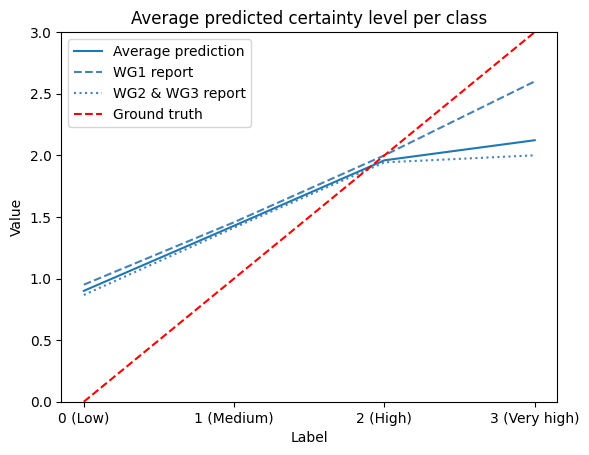

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='Average prediction')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()